In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import sys
import time
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

sys.path.append('../src/')

from utils import *
from greedy_topology_optimization import monte_carlo_step
from iterative_geometry_solver import iterative_geometry_solver

In [6]:
# comparison to greedy heuristic:
np.random.seed(17)
N = 100
terminals_list = [5, 6, 7, 8, 9]
dim_arr = [2, 3, 5, 10, 100]

all_brute_force_costs = np.zeros((len(dim_arr), N*len(terminals_list)))
all_heuristic_costs = np.zeros((len(dim_arr), N*len(terminals_list)))
all_sizes = np.zeros((len(dim_arr), N*len(terminals_list))) 

for k, dim in enumerate(tqdm(dim_arr)):
    # open brute force files:
    pkl_file_path = f"../results/output_files/brute_force/brute-force_dim{dim}_results{N}.pkl"
    pkl_file = open(pkl_file_path, 'rb')
    data_dict = pickle.load(pkl_file)
    pkl_file.close()
    
    for key in data_dict:
        #print(key)

        solution = data_dict[key]
        bot_problem_dict = solution["bot_problem_dict"]
        overall_best_topo = solution["overall_best_topo"]
        overall_best_cost = solution["overall_best_cost"]
        all_brute_force_costs[k, key] = overall_best_cost

        al = bot_problem_dict["al"]
        coords_sources = bot_problem_dict["coords_sources"]
        coords_sinks = bot_problem_dict["coords_sinks"]
        supply_arr = bot_problem_dict["supply_arr"]
        demand_arr = bot_problem_dict["demand_arr"]
        all_sizes[k, key] = len(supply_arr) + len(demand_arr)

        # compare to MC heuristic:
        # use random tree as init:
        topo = generate_random_binary_tree_topo(len(supply_arr) + len(demand_arr))

        cost, coords_iter = iterative_geometry_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-6, min_iterations=-1,
                                                 max_iterations=1000,
                                                 plot=False, title="", fov=None, save=False, save_name="img")

        # MC iterations:
        T = 0
        keep_going = True
        iteration = 0
        sample_edge_list = list(topo.edges())
        while keep_going and iteration < 60000:
            iteration += 1
            topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                            coords_iter, bot_problem_dict, temperature=T)

            # check if converged:
            if len(sample_edge_list) == 0:
                # this means that we have stuck with one topology for an entire run through.
                keep_going = False
                
        
        all_heuristic_costs[k, key] = cost
        
# reshape the cost arrays:
all_brute_force_costs = all_brute_force_costs.reshape((len(dim_arr), len(terminals_list), N))
all_heuristic_costs = all_heuristic_costs.reshape((len(dim_arr), len(terminals_list), N))
all_sizes = all_sizes.reshape((len(dim_arr), len(terminals_list), N))

  0%|          | 0/5 [00:00<?, ?it/s]


dim=2


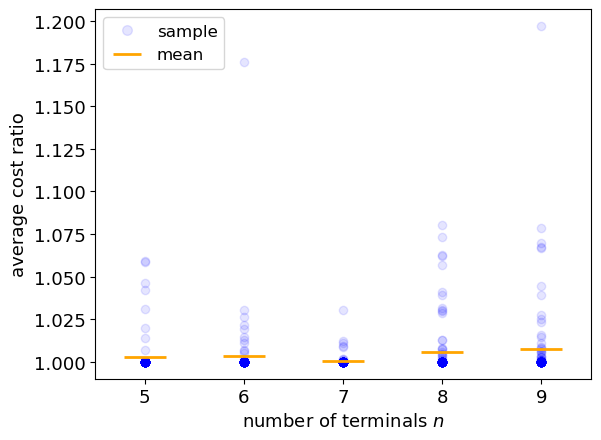


dim=3


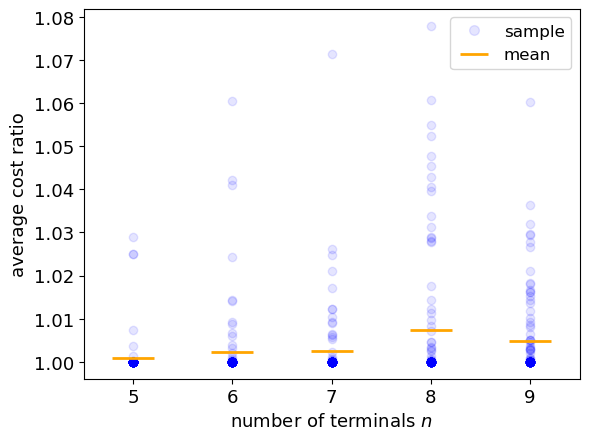


dim=5


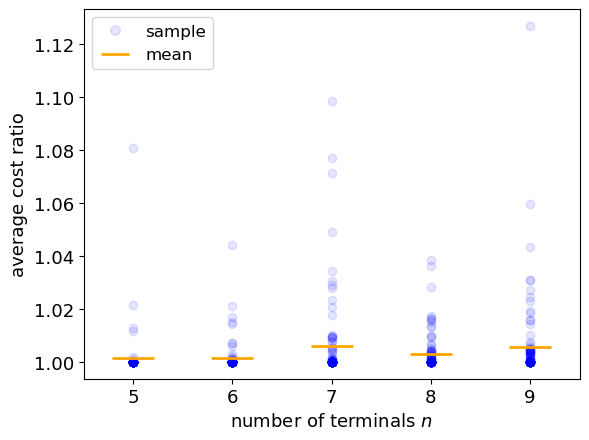


dim=10


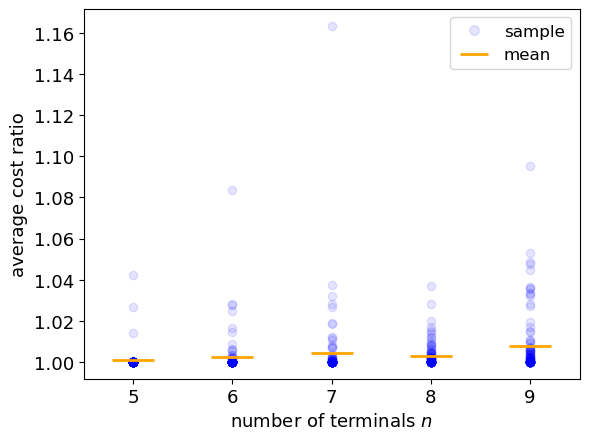


dim=100


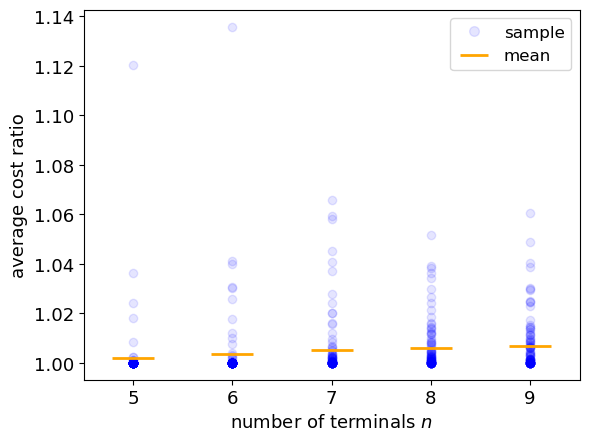

In [3]:
# take ratio:
all_ratio_arr = all_heuristic_costs / all_brute_force_costs

for k, dim in enumerate(dim_arr):
    print(f"\ndim={dim}")
    ratio_arr_star = all_ratio_arr[k]
    # plotting the ratios:
    ratio_arr = np.clip(ratio_arr_star, 1.0, None)

    for i in range(N):
        if i == 0:
            plt.plot(terminals_list, ratio_arr[:, i], "bo", alpha = 0.1, label="sample")
        else:
            plt.plot(terminals_list, ratio_arr[:, i], "bo", alpha = 0.1)
    plt.plot(terminals_list, np.mean(ratio_arr_star, axis = 1), marker="_", markersize=30, mew=2, linestyle="", color="orange", label="mean")
    legend = plt.legend(fontsize=12)
    sizes = [7,20]
    for i,legend_handle in enumerate(legend.legendHandles):
        legend_handle.set_markersize(sizes[i])
    plt.xlabel("number of terminals $n$", fontsize=13)
    plt.ylabel("average cost ratio", fontsize=13)
    #plt.grid()
    plt.xticks(terminals_list, fontsize=13)
    plt.yticks( fontsize=13)
    plt.xlim(4.5,9.5)
    #plt.savefig("MCratio.pdf", bbox_inches="tight")
    plt.show()

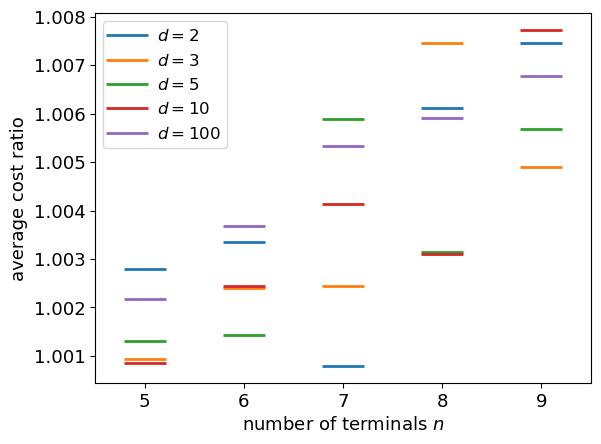

In [4]:
# combine averages into one plot:

# take ratio:
all_ratio_arr = all_heuristic_costs / all_brute_force_costs

for k, dim in enumerate(dim_arr):
    ratio_arr_star = all_ratio_arr[k]
    # plotting the ratios:
    ratio_arr = np.clip(ratio_arr_star, 1.0, None)

    # for i in range(N):
    #     if i == 0:
    #         plt.plot(terminals_list, ratio_arr[:, i], "bo", alpha = 0.1, label="sample")
    #     else:
    #         plt.plot(terminals_list, ratio_arr[:, i], "bo", alpha = 0.1)
    plt.plot(terminals_list, np.mean(ratio_arr_star, axis = 1), marker="_", markersize=30, mew=2, linestyle="", label=f"$d=${dim}")
legend = plt.legend(fontsize=12)
# sizes = [7,20]
# for i,legend_handle in enumerate(legend.legendHandles):
#     legend_handle.set_markersize(sizes[i])
plt.xlabel("number of terminals $n$", fontsize=13)
plt.ylabel("average cost ratio", fontsize=13)
#plt.grid()
plt.xticks(terminals_list, fontsize=13)
plt.yticks( fontsize=13)
plt.xlim(4.5,9.5)
#plt.savefig("MCratio.pdf", bbox_inches="tight")
plt.show()